# Plotting ChIP signal in windows around TSS of DEGs after 24h NipBL depletion

Investigating relationship between differential expression due to depletion of NipBL and interesting proteins:

* CTCF
* RAD21 
* nipbl
* ring1b
* H3K27Ac 

Assuming: anything not in the final 1-day significant results table have no significant dysregulation `EA18.1_ESC_1d-depletion_DESeq2/20220817_EA18-1_resSig_ESC_1d-depletion.csv` 

In [1]:
import plotting_heatmap_functions as pfn

In [2]:
import pandas as pd
import numpy as np
import bbi
from gffutils.helpers import asinterval
from gtfparse import read_gtf
import bioframe as bf
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [3]:
# Importing day 1 depletion in ESCs DEGS

proj = "/project/fudenber_735/collaborations/karissa_2022/20220812_EA18-1_RNAseq-Analysis_forGeoff/"

day1_sigRes = 'EA18.1_ESC_1d-depletion_DESeq2/20220817_EA18-1_resSig_ESC_1d-depletion.csv'

normalized_counts = 'EA18.1_ESC_1d-depletion_DESeq2/20220817_EA18-1_ESC-1d_sf-normalized.csv'

feature_counts = '20220816_featureCounts.csv'

WT_samples = ['KHRNA1', 'KHRNA7', 'KHRNA13', 'KHRNA22', 'KHRNA23', 'KHRNA50']

In [4]:
day1_res_df = pd.read_csv(proj+day1_sigRes)

importing the rest of the feature counts to collect the set of non-significantly DE genes

In [5]:
feat_counts_df = pd.read_csv(proj+feature_counts)

In [6]:
day1_res_df = day1_res_df.merge(feat_counts_df['Geneid'], how='outer')

In [7]:
day1_res_df.shape

(55421, 5)

Getting the TSSes 

Note: assuming that the RNA-seq alignment is still being done via STAR method from 

In [8]:
# Getting TSSEs
tss_df = read_gtf("/project/fudenber_735/collaborations/karissa_2022/old/RNAseq/STAR_Gencode_alignment/tss_annotions_gencode.vM23.primary_assembly.gtf")

/home1/pokorny/.conda/envs/bioenv/lib/python3.9/site-packages/gtfparse/read_gtf.py:82: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  chunk_iterator = pd.read_csv(
/home1/pokorny/.conda/envs/bioenv/lib/python3.9/site-packages/gtfparse/read_gtf.py:82: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  chunk_iterator = pd.read_csv(
INFO:root:Extracted GTF attributes: ['gene_id', 'transcript_id', 'gene_type', 'gene_name', 'transcript_type', 'transcript_name', 'level', 'transcript_support_level', 'mgi_id', 'tag', 'havana_gene', 'havana_transcript', 'protein_id', 'ccdsid', 'ont']


In [9]:
# cleaning out less-well defined chromosome numbers
tss_df = tss_df.loc[False==( tss_df['seqname'].str.contains('NT_'))]
tss_df = tss_df.loc[False==( tss_df['seqname'].str.contains('MT'))]

# paste 'chr' to all chromosome names
tss_df["seqname"] = tss_df["seqname"]

# rename column to chrom to match bedframe/bioframe format
tss_df = tss_df.rename(columns= {"seqname" : "chrom"})

# Removing pseudo chromosomes
before = len(tss_df)
tss_df = tss_df.loc[False==( tss_df['chrom'].str.contains('chrGL'))]
tss_df = tss_df.loc[False==( tss_df['chrom'].str.contains('chrJH'))]
tss_df = tss_df.loc[False==( tss_df['chrom'].str.contains('chrX'))]
tss_df = tss_df.loc[False==( tss_df['chrom'].str.contains('chrY'))]
tss_df = tss_df.loc[False==( tss_df['chrom'].str.contains('chrM'))]
tss_df =tss_df.loc[True==tss_df['chrom'].str.contains('chr')]
after = len(tss_df)

In [10]:
#tss_df['chrom'].value_counts()

In [11]:
#tss_df.head(10)

In [12]:
# drop duplicate TSSes
ts_intervals = tss_df[['gene_id','chrom', 'start', 'end']].drop_duplicates(['gene_id'])

In [13]:
#day1_res_df

In [14]:
#ts_intervals

In [15]:
# drop gene from data field if there is no change associated
# day1_res_df.dropna(subset=['log2FoldChange'], inplace=True)
day1_res_df = day1_res_df.merge(ts_intervals, left_on='Geneid', right_on='gene_id', how='left')

In [16]:
# Checking if any of the significant genes will be lost due to loss of TSS annotation
print("Checking for 'lost' significant genes: ")
ix = np.where(day1_res_df['start'].isna() & (day1_res_df['padj'] < 0.05))
print("lost: ", str(day1_res_df.iloc[ix].shape[0]))

# If could not find a TSS, drop entire row
day1_res_df.dropna(subset=['start'], inplace=True)

Checking for 'lost' significant genes: 
lost:  55


In [17]:
day1_res_df = bf.sanitize_bedframe(day1_res_df)

In [18]:
day1_res_df['log2FoldChange'].tail(1).isna()

51164    True
Name: log2FoldChange, dtype: bool

In [19]:
def label_DE_status_deseq2(gene_row):
    
    cutoff_col = 'padj'
    pval_cutoff = 0.05
    de_value_col = 'log2FoldChange'
    
    if gene_row[cutoff_col] < pval_cutoff:
        if gene_row[de_value_col] < 0:
            return 'down'
        else:
            return 'up'
    return 'nonsig'

In [20]:
day1_res_df['DE_status'] = day1_res_df.apply(lambda row: label_DE_status_deseq2(row), axis=1)

In [21]:
#day1_res_df.drop_duplicates(subset=['chrom', 'start', 'end'])

Where is ChIP relative to dysregulated genes? 

Interesting proteins: For Rad21? For CTCF? For Nipbl? Polycomb proteins (RING1B, SUZ12)?

In [22]:
# Load Chip-Seq files 
chip_folder = "/project/fudenber_735/collaborations/karissa_2022/2022_09_features_for_RNAseq/ChIP-seq_in_WT-parental-E14/"

ctcf_new = "CTCF_E14_RSC13new-22-37-60_average.bw"
rad21 = "RAD21_E14_RSC12new-21-36-59-74_average.bw"
nipbl = "NIPBL_E14_EA112-EA175_average.bw"
ring1b = "RING1B_E14_RSC24-39-62_average.bw"
promoter = "H3K27Ac_mESCs_EA92-EA94_average.bw"

In [23]:
chip_seq_condition_dict = {'CTCF' : chip_folder+ctcf_new, 'RAD21' : chip_folder+rad21,
                           'NiBL' : chip_folder+nipbl, 'RING1B' : chip_folder+ring1b,
                           'H3K27ac' : chip_folder+promoter}

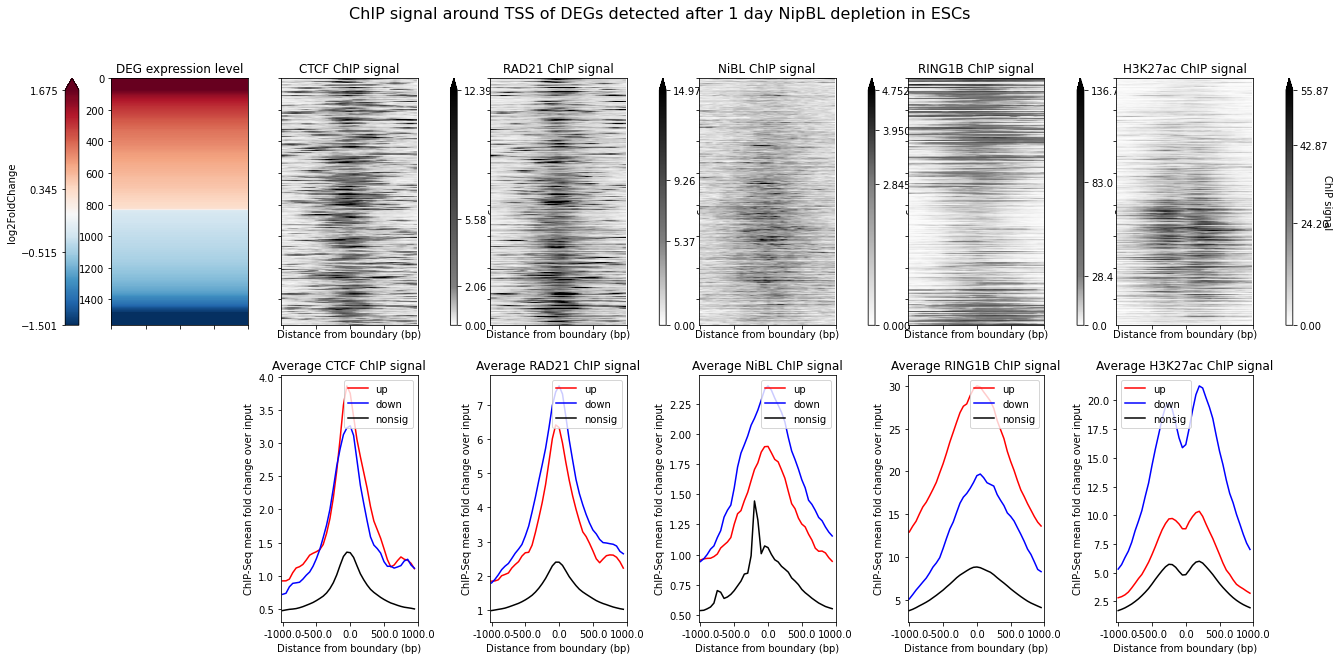

In [24]:
num_conditions = len(chip_seq_condition_dict)
num_deg_sets = 1
widths = [0.1, 1]*num_deg_sets+[1, 0.05]*num_conditions

fig = plt.figure(figsize=(22, 10))
fig.suptitle(('ChIP signal around TSS of DEGs '
             'detected after 1 day NipBL depletion in ESCs'),
             fontsize=16)
gs0 = gridspec.GridSpec(2, 2*(num_conditions+num_deg_sets), 
                              figure=fig, 
                              width_ratios=widths)

gs0.update(wspace=0.45, hspace=0.2)
#gs00 = gs0[1].subgridspec(2, 4, 'width_ratios'=[.05,1,1,.05])
cax1 = fig.add_subplot(gs0[0, 0])
ax1 = fig.add_subplot(gs0[0, 1])

pfn.plot_category_heatmap(day1_res_df, 
                          plot_title="""DEG expression level""",
                          ax=ax1,
                          cax=cax1
                          )

last_ax = 1
for cond, chip_file in chip_seq_condition_dict.items():
                        
    ax2 = fig.add_subplot(gs0[0, last_ax+1], sharey=ax1)
    cax2 = fig.add_subplot(gs0[0, last_ax+2])
    ax3 = fig.add_subplot(gs0[1, last_ax+1], sharex=ax2)
    last_ax=last_ax+2
    plt.setp(ax2.get_xticklabels(), visible=False)
    plt.setp(ax2.get_yticklabels(), visible=False)

    matrix = pfn.generate_signal_matrix(day1_res_df,
                                    chip_file
                                    )

    pfn.plot_binned_signal_heatmap(day1_res_df, 
                                  matrix, 
                                  plot_title=("{} ChIP signal".format(cond)),
                                  ax=ax2,
                                  cax=cax2
                                  )
    
    pfn.plot_avg_signal(day1_res_df, 
                        matrix, 
                        plot_title="Average {} ChIP signal".format(cond),
                        ax=ax3)

plt.savefig('20221012_1day_dNipBL_ChIP_spaced.png')
plt.show()

In [ ]:
!pwd

### Extending window to +/- 100kbp

### Window +/- 10kbp

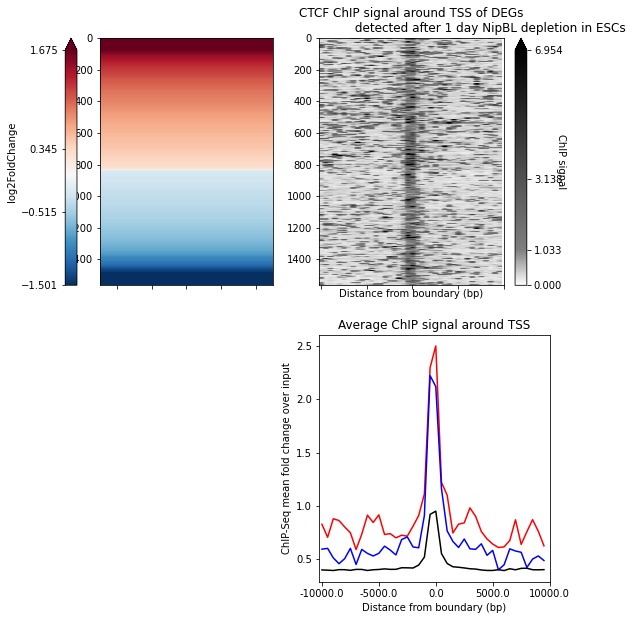

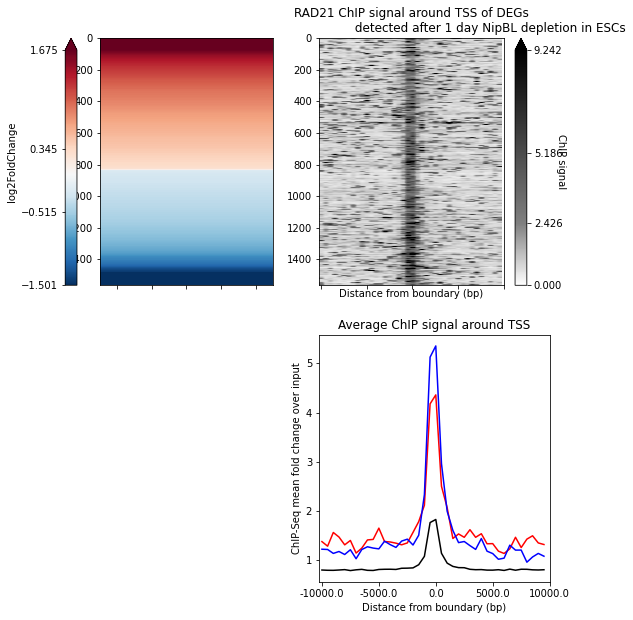

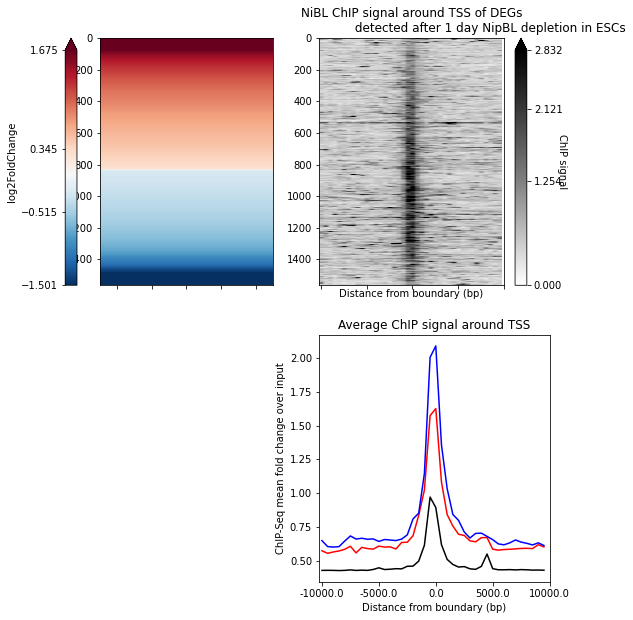

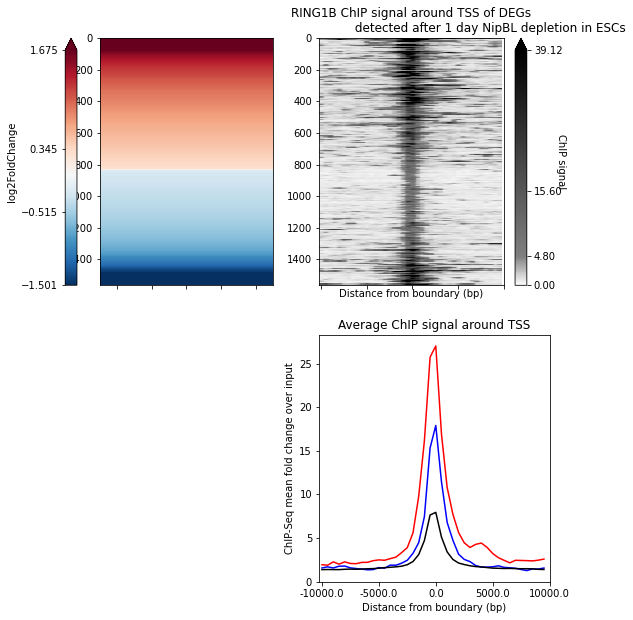

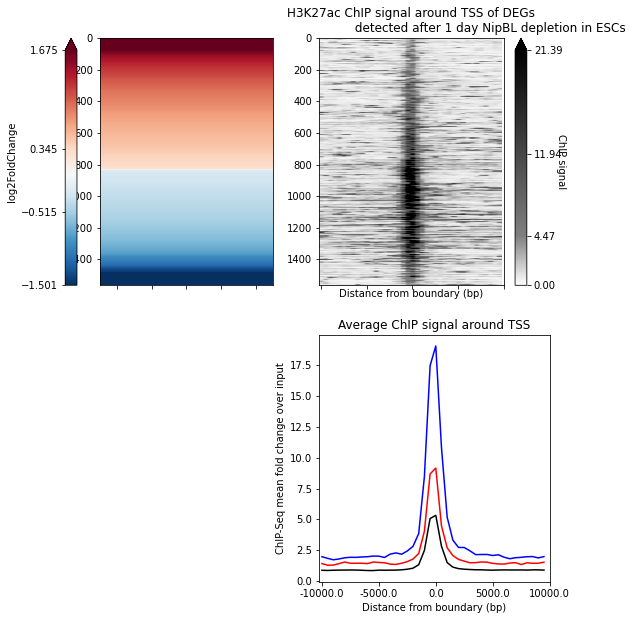

In [32]:
medium_window = 10000
for cond, chip_file in chip_seq_condition_dict.items():
    
    fig = plt.figure(figsize=(20, 10))
    gs0 = gridspec.GridSpec(1, 2, figure=fig)
    gs00 = gs0[1].subgridspec(2, 2)
    
    ax1 = fig.add_subplot(gs00[0, 0])
    ax2 = fig.add_subplot(gs00[0, 1])
    ax3 = fig.add_subplot(gs00[1, 1], sharex=ax2)
    plt.setp(ax2.get_xticklabels(), visible=False)
    
    matrix = pfn.generate_signal_matrix(day1_res_df,
                                        chip_file,
                                        window_size=medium_window
                                        )
    
    
    
    pfn.plot_binned_signal_heatmap(day1_res_df, 
                                  matrix, 
                                  plot_title="""{} ChIP signal around TSS of DEGs
                                         detected after 1 day NipBL depletion in ESCs""".format(cond),
                                  ax=ax2,
                                  window_size=medium_window  
                                  )
    
    pfn.plot_category_heatmap(day1_res_df, 
                              title="""DEG expression level detected after 1
                                  day NipBL depletion in ESCs""".format(cond),
                              ax=ax1
                              )
    
    pfn.plot_avg_signal(day1_res_df, 
                        matrix, 
                        plot_title="Average ChIP signal around TSS",
                        ax=ax3,
                        window_size=medium_window)
    
    
    plt.show()